In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

In [2]:
start = "2015-01-01"

In [3]:
overall = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [ ]:
overall.head(5)

In [6]:
stocks = overall.Symbol

In [8]:
stocks.head(5)

0     MMM
1     AOS
2     ABT
3    ABBV
4     ACN
Name: Symbol, dtype: object

In [ ]:
stocks = stocks.to_list()

In [10]:
overall= overall[overall['Date added'] >= start]

In [13]:
# retriving removed companies and when
# first step to voercome survival bias
removed = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[1][['Date','Removed']]

In [16]:
removed = removed.set_index(removed.Date.Date) #setting the index as the date column

In [17]:
removed.index = pd.to_datetime(removed.index) #changing to datetime

In [18]:
removed = removed[removed.index >= start]

In [19]:
removed = removed.Removed.dropna()

In [20]:
stocks.extend(removed.Ticker.to_list()) #including removed tickers to our stocks

In [ ]:
df = yf.download(stocks,start=start)['Close']

In [23]:
df.index = pd.to_datetime(df.index)

In [30]:
df['SBNY'].index <= removed[removed.Ticker == 'SBNY'].index[0] #filtering until the date it was excluded

array([ True,  True,  True, ..., False, False, False])

In [32]:
df['SBNY'] = df['SBNY'][df['SBNY'].index <= removed[removed.Ticker == 'SBNY'].index[0]]
df['SBNY']

Date
2015-01-02    125.250000
2015-01-05    121.809998
2015-01-06    120.360001
2015-01-07    120.970001
2015-01-08    124.080002
                 ...    
2023-09-07           NaN
2023-09-08           NaN
2023-09-11           NaN
2023-09-12           NaN
2023-09-13           NaN
Name: SBNY, Length: 2189, dtype: float64

In [36]:
# Filtering out all removed tickers
def pricefilter_rem(ticker):
  df[ticker] = df[ticker][df[ticker].index <= removed[removed.Ticker == ticker].index[0]]

In [37]:
def pricefilter_add(ticker):
  df[ticker] = df[ticker][df[ticker].index >= overall[overall.Symbol == ticker]['Date added'].values[0]]

In [38]:
for ticker_rem in removed.Ticker:
  pricefilter_rem(ticker_rem)
for ticker_add in overall.Symbol:
  pricefilter_add(ticker_add)

In [ ]:
# Strategy building, Backtesting and Benchmark Comparison

In [ ]:
# Strategy:
# check the past 12m performance of all stocks
# buy the top performers and hold them for one month

In [39]:
ret_df = df.pct_change()

In [40]:
mtl_ret = (ret_df + 1).resample('M').prod()  #accumulating returns on a monthly basis

In [41]:
# Calculating past 12 months return
mtl_12 = mtl_ret.rolling(12).apply(np.prod).dropna()

In [42]:
mtl_12.head(1)
# Ex. Apple was falling by 4% until 2015-12-31

,A,AA,AAL,AAP,AAPL,ABBV,ABMD,ABT,ACE,ACGL,...,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,1.030819,0.621536,0.778493,0.949231,0.962773,0.899074,2.419726,1.000223,1.0,1.0,...,0.839707,1.17177,0.773091,0.958508,1.0,1.009675,0.911182,1.0,0.965005,1.106442


In [44]:
# Building filtering mechanism to find top 5 perfomers for any given day
top = mtl_12.loc['2015-12-31'].nlargest(5)
# one dollar in Amazon would have been 2.19 dollars after 12 months

ABMD    2.419726
NFLX    2.294549
AMZN    2.190749
AYI     1.671433
NVDA    1.637357
Name: 2015-12-31 00:00:00, dtype: float64

In [ ]:
mtl_ret[top.name:][1:2]
#filtering the top perfomers by the name property (which is the date),
# then we exclude that date and take the next row

In [47]:
relevant_ret = mtl_ret[top.name:][1:2][top.index] #getting top performers only

In [48]:
relevant_ret.mean(axis=1)
# had we bought the top 5 performing stocks of the last 12 months ending in december 2015, the return would have been roughlt -12.6%

Date
2016-01-31    0.874214
Freq: M, dtype: float64

In [49]:
# Getting the portfolio return for a given date
def top_performers(date):
  all = mtl_12.loc[date]
  top = all.nlargest(5)
  relevant_ret = mtl_ret[top.name:][1:2][top.index]
  return (relevant_ret).mean(axis=1).values[0]

In [51]:
top_performers('2015-12-31')

0.874214231913179

In [52]:
# getting all relevant dates and storing the returns in a list (skipping the last element)
returns = []
for date in mtl_12.index[:-1]:
  returns.append(top_performers(date))

In [53]:
pd.Series(returns).prod()
# roughly 321% return

3.2081858205466975

<Axes: xlabel='Date'>

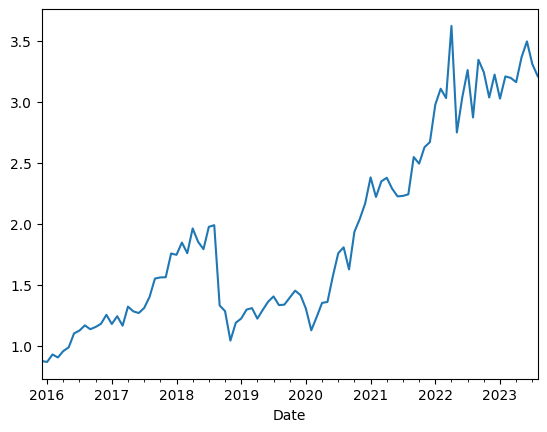

In [54]:
pd.Series(returns, index=mtl_12.index[:-1]).cumprod().plot()

In [ ]:
# Benchmark Comparison
s_p500 = yf.download('^GSPC', start = start).Close

In [56]:
s_p500

Date
2015-01-02    2058.199951
2015-01-05    2020.579956
2015-01-06    2002.609985
2015-01-07    2025.900024
2015-01-08    2062.139893
                 ...     
2023-09-07    4451.140137
2023-09-08    4457.490234
2023-09-11    4487.459961
2023-09-12    4461.899902
2023-09-13    4478.220215
Name: Close, Length: 2189, dtype: float64

In [57]:
4478.220215/2058.199951
# the strategy clearly outperforms the S&P

2.1757945397016485